# SVD to Analyze COVID-19 Data
This notebook is used to process data about the current COVID-19 pandemic to identify factors that explain the virus's varied impact in different counties across the US. The two datasets used, US Census Demographic Data$^{1}$ and US Counties: COVID19 + Weather + Socio/Health data$^{2}$, are both publicly available. 

In [596]:
import pandas as pd
import time
import datetime

## 1. Pulling Data
Collecting data from both the census dataset and the kaggle covid19 dataset.

In [597]:
census_df = pd.read_csv('us-census-demographic-data/acs2017_county_data.csv').drop(columns=['CountyId'])
census_df.head()

,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,...,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,...,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,...,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,...,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,...,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


In [598]:
covid_df = pd.read_csv('us-counties-covid19-weather-sociohealth-data/US_counties_COVID19_health_weather_data.csv')\
             .drop(columns=['num_deaths','num_deaths_2','num_deaths_3','num_deaths_4','num_deaths_5'])
covid_df.head()

,date,county,state,fips,cases,deaths,stay_at_home_announced,stay_at_home_effective,lat,lon,...,min_temp_3d_avg,min_temp_5d_avg,min_temp_10d_avg,min_temp_15d_avg,dewpoint_3d_avg,dewpoint_5d_avg,dewpoint_10d_avg,dewpoint_15d_avg,date_stay_at_home_announced,date_stay_at_home_effective
0,2020-01-21,Snohomish,Washington,53061,1,0,no,no,48.047489,-121.697307,...,38.266667,38.92,38.44,36.146667,40.333333,41.64,40.74,37.973333,2020-03-23,2020-03-23
1,2020-01-22,Snohomish,Washington,53061,1,0,no,no,48.047489,-121.697307,...,39.233333,41.12,39.76,37.613333,42.633333,42.98,41.68,39.440000,2020-03-23,2020-03-23
2,2020-01-23,Snohomish,Washington,53061,1,0,no,no,48.047489,-121.697307,...,42.900000,41.74,41.15,38.226667,44.733333,43.72,42.47,40.120000,2020-03-23,2020-03-23
3,2020-01-24,Cook,Illinois,17031,1,0,no,no,41.840039,-87.816716,...,32.366667,30.02,27.43,24.886667,31.433333,28.50,25.00,22.693333,2020-03-20,2020-03-21
4,2020-01-24,Snohomish,Washington,53061,1,0,no,no,48.047489,-121.697307,...,44.600000,42.54,41.75,38.226667,46.000000,44.30,42.88,41.293333,2020-03-23,2020-03-23


## 2. Helper functions

These functions standardize the county names to be lowercase and without the word county at the end, change dates to timestamps so that they're numerical values, and change the words 'yes'/'no' to booleans respectively. This allows data to be consistent between the databases and for all of the datatypes in the dataset to be numerical.

In [599]:
def remove_county_word(word):
    word = word.lower()
    if word.endswith('county'):
        word = word[:-7]
    return word

def date_to_timestamp(date):
    if type(date) != str:
        return current_time
    return time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple())

def change_to_bool(word):
    return 1 if word == 'yes' else 0

## 3. Process Datasets Individually

Applies helpers to relevant columns in each of the datasets and groups both by state/county since there are many counties that share names with counties in other states.

In [600]:
current_time = time.time()

covid_df['county'] = covid_df['county'].apply(lambda x: remove_county_word(x))
covid_df['stay_at_home_effective'] = covid_df['stay_at_home_effective'].apply(lambda x: change_to_bool(x))
covid_df['stay_at_home_announced'] = covid_df['stay_at_home_announced'].apply(lambda x: change_to_bool(x))
covid_df['date_stay_at_home_announced'] = covid_df['date_stay_at_home_announced'].apply(lambda x: date_to_timestamp(x))
covid_df['date_stay_at_home_effective'] = covid_df['date_stay_at_home_effective'].apply(lambda x: date_to_timestamp(x))

cols = covid_df.columns.drop(['state','county','date','fips','CALL','station_name','precip_flag'])
covid_df[cols] = covid_df[cols].apply(pd.to_numeric)
counted_measurements = ['fog','rain','snow','hail','thunder','tornado']
maxed_measurements = ['deaths','cases']
aggregation_map = {}
for measurement in cols:
    if measurement in counted_measurements:
        aggregation_map[measurement] = 'count'
    elif measurement in maxed_measurements:
        aggregation_map[measurement] = 'max'
    else:
        aggregation_map[measurement] = 'mean'
        
covid_df = covid_df.groupby(['state','county'],as_index=False).agg(aggregation_map)

In [601]:
census_df['County'] = census_df['County'].apply(lambda x: remove_county_word(x))
census_df = census_df.groupby(['County','State'],as_index=False).mean()\
                     .rename(columns={'County':'county','State':'state'})

## 4. Combine Datasets

Join the two processesed datasets to create one dataset to perform PCA by combining on county/state for the same reason we grouped them this way.

In [602]:
dataset = pd.merge(census_df,covid_df,on=['county','state'])

In [603]:
dataset.shape

(2803, 251)

In [604]:
dataset.head()

,county,state,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,min_temp_3d_avg,min_temp_5d_avg,min_temp_10d_avg,min_temp_15d_avg,dewpoint_3d_avg,dewpoint_5d_avg,dewpoint_10d_avg,dewpoint_15d_avg,date_stay_at_home_announced,date_stay_at_home_effective
0,abbeville,South Carolina,24788,12044,12744,1.3,68.9,27.6,0.1,0.3,...,48.613333,48.506818,48.227317,48.313504,49.680741,49.650000,49.506585,49.479145,1.588967e+09,1.588967e+09
1,accomack,Virginia,32840,16079,16761,8.8,60.3,28.3,0.3,0.7,...,45.734884,45.438571,45.057692,44.849369,45.982946,45.723333,45.354872,45.062883,1.585552e+09,1.585552e+09
2,ada,Idaho,435117,217999,217118,7.9,85.2,1.2,0.4,2.6,...,36.883660,36.607600,35.945957,35.455852,30.971895,30.805600,30.254681,29.750370,1.585120e+09,1.585120e+09
3,adair,Iowa,7192,3552,3640,1.7,96.6,0.3,0.0,0.4,...,38.204255,37.869565,37.199070,36.580488,38.809091,38.581951,37.789091,37.436000,1.588967e+09,1.588967e+09
4,adair,Kentucky,19304,9632,9672,1.8,93.4,3.6,0.1,0.1,...,44.104348,44.010909,42.980000,42.997647,41.081159,40.667273,39.246316,39.256863,1.584860e+09,1.585206e+09


## 4. Save Combined Dataset
Saves locally for further analysis.

In [779]:
dataset = dataset.drop(columns=['hi'])
dataset = dataset.fillna(dataset.mean())
dataset.to_csv('covid_dataset.csv')

# PCA Through SVD
Here we will explore using the SVD of our dataset/matrix to learn more about the principle components affecting the COVID-19 pandemic. We used an approach based on the code by Sebastian Raschka found [here](https://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/dimensionality_reduction/projection/principal_component_analysis.ipynb). $^3$

In [780]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import altair as alt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import cycle
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
import warnings
warnings.filterwarnings(action='ignore')
output_notebook()
%matplotlib inline

Loading BokehJS ...

## 1. Loading Data

Here we load the X,y for our dataset and drop irrelevant/redundant columns.

In [809]:
df = pd.read_csv('covid_dataset.csv')
drop_cols = ['Unnamed: 0','county','state','deaths','cases','station_id']
for col in df.columns.values:
    if 'pop' in col.lower() and col != 'TotalPop':
        drop_cols.append(col)

X = df.drop(columns=drop_cols)
labels = range(2)
df['Class type'] = pd.qcut(df['cases'],len(labels)+1,duplicates='drop',labels=False)
y = df['Class type']

feature_dict = X.columns.values
X.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,...,min_temp_3d_avg,min_temp_5d_avg,min_temp_10d_avg,min_temp_15d_avg,dewpoint_3d_avg,dewpoint_5d_avg,dewpoint_10d_avg,dewpoint_15d_avg,date_stay_at_home_announced,date_stay_at_home_effective
0,24788,12044,12744,1.3,68.9,27.6,0.1,0.3,0.0,19452,...,48.613333,48.506818,48.227317,48.313504,49.680741,49.650000,49.506585,49.479145,1.588967e+09,1.588967e+09
1,32840,16079,16761,8.8,60.3,28.3,0.3,0.7,0.0,24408,...,45.734884,45.438571,45.057692,44.849369,45.982946,45.723333,45.354872,45.062883,1.585552e+09,1.585552e+09
2,435117,217999,217118,7.9,85.2,1.2,0.4,2.6,0.1,316189,...,36.883660,36.607600,35.945957,35.455852,30.971895,30.805600,30.254681,29.750370,1.585120e+09,1.585120e+09
3,7192,3552,3640,1.7,96.6,0.3,0.0,0.4,0.0,5572,...,38.204255,37.869565,37.199070,36.580488,38.809091,38.581951,37.789091,37.436000,1.588967e+09,1.588967e+09
4,19304,9632,9672,1.8,93.4,3.6,0.1,0.1,0.0,15280,...,44.104348,44.010909,42.980000,42.997647,41.081159,40.667273,39.246316,39.256863,1.584860e+09,1.585206e+09


## 2. Per Label Feature Histograms 
Shows how the labels are separated for each of the ~250 features.

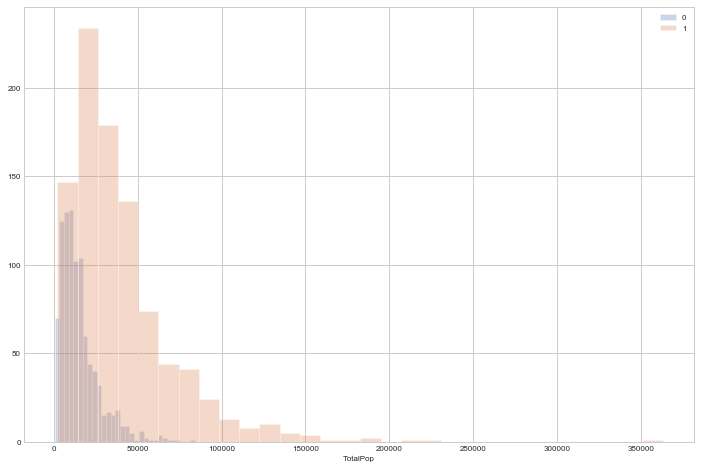

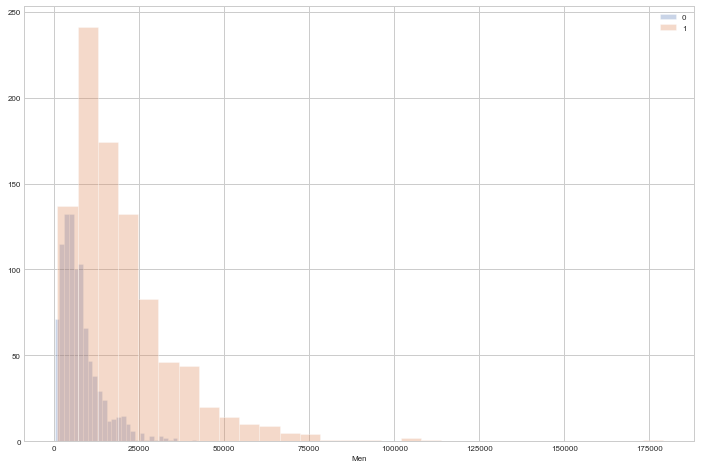

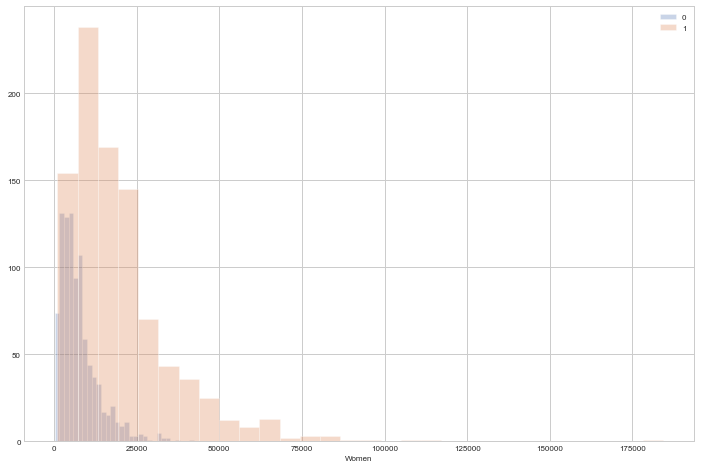

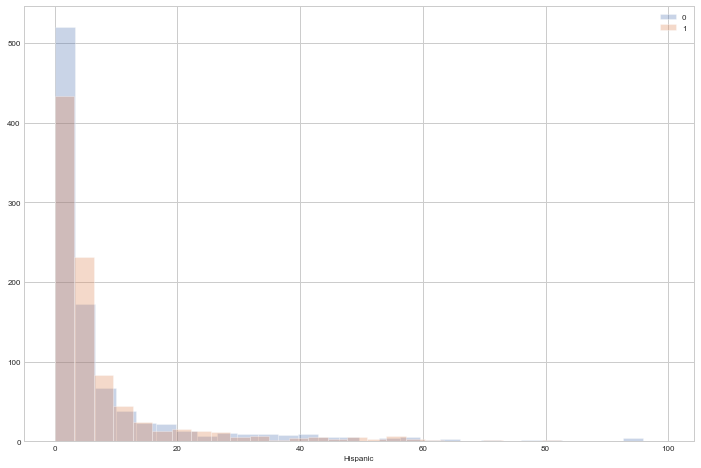

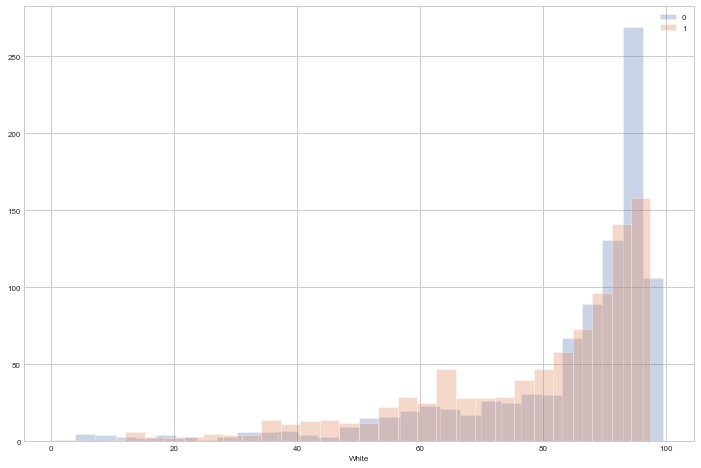

<Figure size 432x288 with 0 Axes>

In [782]:
with plt.style.context('seaborn-whitegrid'):
    for feat in feature_dict[:5]: # Only showing first 5 features
        plt.figure(figsize=(12, 8))
        for lab in labels:
            rows = df.loc[df['Class type'] == lab]
            toplot = rows[feat]
            plt.hist(toplot,
                    label=lab,
                    bins=30,
                    alpha=0.3,)
        plt.xlabel(feat)
        plt.legend(loc='upper right', fancybox=True, fontsize=8)
        plt.show()

    plt.tight_layout()
    plt.show()

# 3. Perform PCA

Using the SVD to perfom PCA on our dataset.

In [783]:
X_std = StandardScaler().fit_transform(X)

u, s, v = np.linalg.svd(X_std.T)
eig_vecs = u

# Get eigenvalues from s
eig_vals = []
for sv in s:
    eig_vals.append(sv**2)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)


## 4. Generating Plots

### Principal Components vs. Explained Variance Ratio

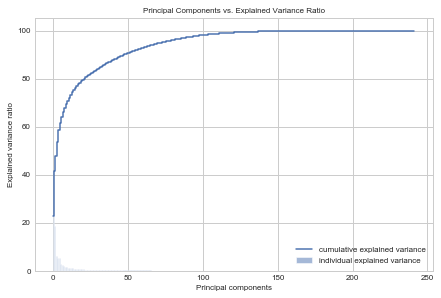

In [798]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(feature_dict)), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(len(feature_dict)), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title('Principal Components vs. Explained Variance Ratio')
    plt.legend(loc='best')
    plt.tight_layout()

### Interactive PC1 vs PC2 Graph
Hovering over each data point reveals the county/state represented by the point.

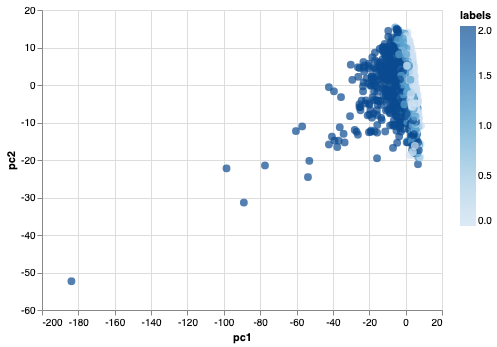

In [818]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(len(feature_dict),1),
                      eig_pairs[1][1].reshape(len(feature_dict),1)))

Y = X_std.dot(matrix_w)
pc_data = pd.DataFrame({'state':df['state'],'county':df['county'],'pc1':Y[:, 0],'pc2':Y[:, 1],'labels': df['Class type']})
chart = alt.Chart(pc_data).mark_circle(size=60).encode(
    x='pc1',
    y='pc2',
    color='labels',
    tooltip=['state', 'county']
).interactive()

chart

### 3D PC1 vs PC2 vs PC3 Graph

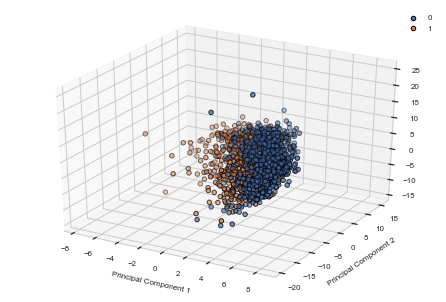

In [793]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(len(feature_dict),1),
                      eig_pairs[1][1].reshape(len(feature_dict),1),
                      eig_pairs[2][1].reshape(len(feature_dict),1)))

#print('Matrix W:\n', matrix_w)

Y = X_std.dot(matrix_w)
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure()
    ax = Axes3D(fig)
    for lab in labels:
        ax.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    Y[y==lab, 2],
                    label=lab,
                    s = 20,
                    edgecolors = 'black')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

## 5. Helper Functions for Correlation Heatmaps
Code based on by Gaurav Kaushik's notebook which can be found [here](https://github.com/gaurav-kaushik/Data-Visualizations-Medium/blob/master/code/Interactive_PCA_and_Feature_Correlation.ipynb).$^4$

In [726]:
def get_float_list(range_max:int, div:int=100) -> list:
    """ To get 0 -> 1, range_max must be same order of mag as div """
    return [float(x)/div for x in range(int(range_max))]


def get_colorcycle(colordict:dict):
    """ Subset cnames with a string match and get a color cycle for plotting """
    return cycle(list(colordict.keys()))


def get_colordict(filter_:str='dark') -> dict:
    """ return dictionary of colornames by filter """
    return dict((k, v) for k, v in cnames.items() if filter_ in k)


def pca_report_interactive(X, scale_X:bool=True, save_plot:bool=False):
    """
    X:          input data matrix
    scale_X:    determine whether to rescale X (StandardScaler) [default: True, X is not prescaled
    save_plot:  save plot to file (html) and not show
    """

    # calculate mean and var
    X_mean, X_var = X.mean(), X.var()
    print('\n*--- PCA Report ---*\n')
    print(f'X mean:\t\t{X_mean:.3f}\nX variance:\t{X_var:.3f}')

    if scale_X:
        # rescale and run PCA
        print("\n...Rescaling data...\n")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_s_mean, X_s_var = X_scaled.mean(), X_scaled.var()
        print(f'X_scaled mean:\t\t{np.round(X_s_mean):.3f}')
        print(f'X_scaled variance:\t{np.round(X_s_var):.3f}\n')
        pca_ = PCA().fit(X_scaled)
        X_pca = PCA().fit_transform(X)
    else:
        # run PCA directly
        print("...Assuming data is properly scaled...")
        pca_ = PCA().fit(X)
        X_pca = PCA().fit_transform(X)
            
    # Get cumulative explained variance for each dimension
    pca_evr = pca_.explained_variance_ratio_
    cumsum_ = np.cumsum(pca_evr)
    
    # Get dimensions where var >= 95% and values for variance at 2D, 3D
    dim_95 = np.argmax(cumsum_ >= 0.95) + 1
    twoD = np.round(cumsum_[1], decimals=3)*100 
    threeD = np.round(cumsum_[2], decimals=3)*100
    instances_, dims_ =  X.shape
    
    # check shape of X
    if dims_ > instances_:
        print("WARNING: number of features greater than number of instances.")
        dimensions = list(range(1, instances_+1))
    else:
        dimensions = list(range(1, dims_+1))
    
    # Print report
    print("\n -- Summary --")
    print(f"You can reduce from {dims_} to {dim_95} dimensions while retaining 95% of variance.")
    print(f"2 principal components explain {twoD:.2f}% of variance.")
    print(f"3 principal components explain {threeD:.2f}% of variance.")
    
    """ - Plotting - """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['PCA'], tooltips=[("dimensions", "@x_dim"), 
                                                ("cumulative variance", "@y_cumvar"),
                                                ("explained variance", "@y_var")])
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # insert 0 at beginning for cleaner plotting
    cumsum_plot = np.insert(cumsum_, 0, 0) 
    pca_evr_plot = np.insert(pca_evr, 0, 0)
    dimensions_plot = np.insert(dimensions, 0, 0)

    """
    ColumnDataSource
    - a special type in Bokeh that allows you to store data for plotting
    - store data as dict (key:list)
    - to plot two keys against one another, make sure they're the same length!
    - below:
        x_dim    # of dimensions (length = # of dimensions)
        y_cumvar # cumulative variance (length = # of dimensions)
        var_95   # y = 0.95 (length = # of dimensions)
        zero_one # list of 0 to 1
        twoD     # x = 2 
        threeD   # x = 3 
    """ 
    
    # get sources
    source_PCA = ColumnDataSource(data=dict(x_dim = dimensions_plot,y_cumvar = cumsum_plot, y_var = pca_evr_plot))    
    source_var95 = ColumnDataSource(data=dict(var95_x = [dim_95]*96, var95_y = get_float_list(96)))
    source_twoD = ColumnDataSource(data=dict(twoD_x = [2]*(int(twoD)+1), twoD_y = get_float_list(twoD+1)))
    source_threeD = ColumnDataSource(data=dict(threeD_x = [3]*(int(threeD)+1), threeD_y = get_float_list(threeD+1)))

    """ PLOT """
    # set up figure and add axis labels
    p = figure(title='PCA Analysis', tools=p_tools)
    p.xaxis.axis_label = f'N of {dims_} Principal Components' 
    p.yaxis.axis_label = 'Variance Explained (per PC & Cumulative)'
    
    # add reference lines: y=0.95, x=2, x=3
    p.line('twoD_x', 'twoD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_twoD) # x=2
    p.line('threeD_x', 'threeD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_threeD) # x=3
    p.line('var95_x', 'var95_y', line_width=2, line_dash='dotted', color='#435363', source=source_var95) # var = 0.95

    # add bar plot for variance per dimension
    p.vbar(x='x_dim', top='y_var', width=.5, bottom=0, color='#D9F2EF', source=source_PCA, name='PCA')
    
    # add cumulative variance (scatter + line)
    p.line('x_dim', 'y_cumvar', line_width=1, color='#F79737', source=source_PCA)
    p.circle('x_dim', 'y_cumvar', size=7, color='#FF4C00', source=source_PCA, name='PCA')

    # change gridlines
    p.ygrid.grid_line_alpha = 0.25
    p.xgrid.grid_line_alpha = 0.25

    # change axis bounds and grid
    p.xaxis.bounds = (0, dims_)
    p.yaxis.bounds = (0, 1)
    p.grid.bounds = (0, dims_)

    # save and show p
    if save_plot:
        output_file('PCA_analysis.html')
    show(p)
        
    # output PCA info as a dataframe
    df_PCA = pd.DataFrame({'dimension': dimensions, 'variance_cumulative': cumsum_, 'variance': pca_evr}).set_index(['dimension'])
        
    return df_PCA, X_pca, pca_evr


def pca_feature_correlation(X, X_pca, explained_var, features:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    1. Get dot product of X and X_pca
    2. Run normalizations of X*X_pca
    3. Retrieve df/matrices

    X:               data (numpy matrix)
    X_pca:           PCA
    explained_var:   explained variance matrix
    features:        list of feature names
    fig_dpi:         dpi to use for heatmaps
    save_plot:       save plot to file (html) and not show
    """
    
    # Add zeroes for data where features > instances
    outer_diff = X.T.shape[0] - X_pca.shape[1]
    if outer_diff > 0: # outer dims must match to get sq matrix
        Z = np.zeros([X_pca.shape[0], outer_diff])
        X_pca = np.c_[X_pca, Z]
        explained_var = np.append(explained_var, np.zeros(outer_diff))
    
    # Get correlation between original features (X) and PCs (X_pca)
    dot_matrix = np.dot(X.T, X_pca)
    print(f"X*X_pca: {X.T.shape} * {X_pca.shape} = {dot_matrix.shape}")
    
    # Correlation matrix -> df
    df_dotproduct = pd.DataFrame(dot_matrix)
    df_dotproduct.columns = [''.join(['PC', f'{i+1}']) for i in range(dot_matrix.shape[0])]
    if any(features): df_dotproduct.index = features    
    
    # Normalize & Sort
    df_n, df_na, df_nabv = normalize_dataframe(df_dotproduct, explained_var, plot_opt=True, save_plot=save_plot)
    
    return df_dotproduct, df_n, df_na, df_nabv


def normalize_dataframe(df, explained_var=None, fig_dpi:int=150, plot_opt:bool=True, save_plot:bool=False):
    """
    1. Get z-normalized df (normalized to µ=0, σ=1)
    2. Get absolute value of z-normalized df
    3. If explained_variance matrix provided, dot it w/ (2)
    """
    # Normalize, Reindex, & Sort
    df_norm = (df.copy()-df.mean())/df.std()
    df_norm = df_norm.sort_values(list(df_norm.columns), ascending=False)
    
    # Absolute value of normalized (& sort)
    df_abs = df_norm.copy().abs().set_index(df_norm.index)
    df_abs = df_abs.sort_values(by=list(df_abs.columns), ascending=False)
    
    # Plot
    if plot_opt:
        # Z-normalized corr matrix
        plt.figure(dpi=fig_dpi)
        ax_normal = sns.heatmap(df_norm, cmap="RdBu")
        ax_normal.set_title("Z-Normalized Data")
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix.png')
        else:
            plt.show()

        # |Z-normalized corr matrix|  
        plt.figure(dpi=fig_dpi)
        ax_abs = sns.heatmap(df_abs, cmap="Purples")
        ax_abs.set_title("|Z-Normalized|")
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix_Abs.png')
        else:
            plt.show()
        
    # Re-normalize by explained var (& sort)
    if explained_var.any():
        df_byvar = df_abs.copy()*explained_var
        df_byvar = df_byvar.sort_values(by=list(df_norm.columns), ascending=False)
        if plot_opt:
            plt.figure(dpi=fig_dpi)
            ax_relative = sns.heatmap(df_byvar, cmap="Purples")
            ax_relative.set_title("|Z-Normalized|*Explained_Variance")
            if save_plot:
                plt.savefig('Normalized_corr_matrix.png')
            else:
                plt.show()
    else:
        df_byvar = None
    return df_norm, df_abs, df_byvar


def pca_rank_features(df_nabv, verbose:bool=True):
    """
    Given a dataframe df_nabv with dimensions [f, p], where:
        f = features (sorted)
        p = principal components
        df_nabv.values are |Z-normalized X|*pca_.explained_variance_ratio_
        
    1. Create column of sum of each row, sort by it 'score_'
    3. Set index as 'rank'
    """
    df_rank = df_nabv.copy().assign(score_ = df_nabv.sum(axis=1)).sort_values('score_', ascending=False)
    df_rank['feature_'] = df_rank.index
    df_rank.index = range(1, len(df_rank)+1)
    df_rank.drop(df_nabv.columns, axis=1, inplace=True)
    df_rank.index.rename('rank', inplace=True)
    if verbose: print(df_rank)
    return df_rank


def pca_full_report(X, features_:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    Run complete PCA workflow:
        1. pca_report_interactive()
        2. pca_feature_correlation()
        3. pca_rank_features()
        
    X:            data (numpy array)
    features_:    list of feature names
    fig_dpi:      image resolution
    
    """
    # Retrieve the interactive report
    df_pca, X_pca, pca_evr = pca_report_interactive(X, save_plot=save_plot)
    # Get feature-PC correlation matrices
    df_corr, df_n, df_na, df_nabv = pca_feature_correlation(X, X_pca, pca_evr, features_, fig_dpi, save_plot) 
    # Get rank for each feature
    df_rank = pca_rank_features(df_nabv)
    return (df_pca, X_pca, pca_evr, df_corr, df_n, df_na, df_nabv, df_rank)




## 6. Find Correlation Heatmaps over all Features/PCs


*--- PCA Report ---*

X mean:		13112399.964
X variance:	20615826741643924.000

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 242 to 74 dimensions while retaining 95% of variance.
2 principal components explain 41.60% of variance.
3 principal components explain 48.00% of variance.


X*X_pca: (242, 2803) * (2803, 242) = (242, 242)


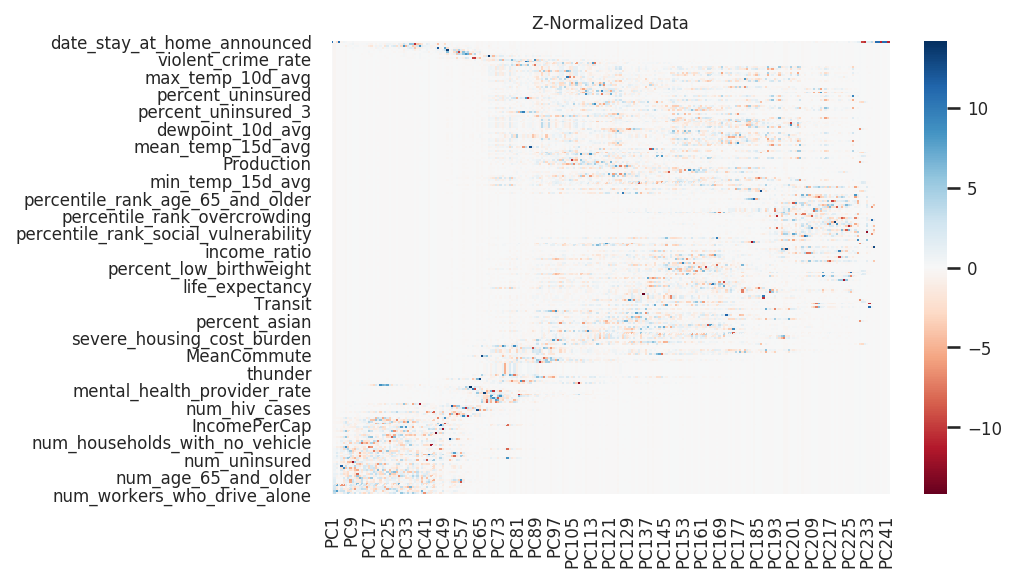

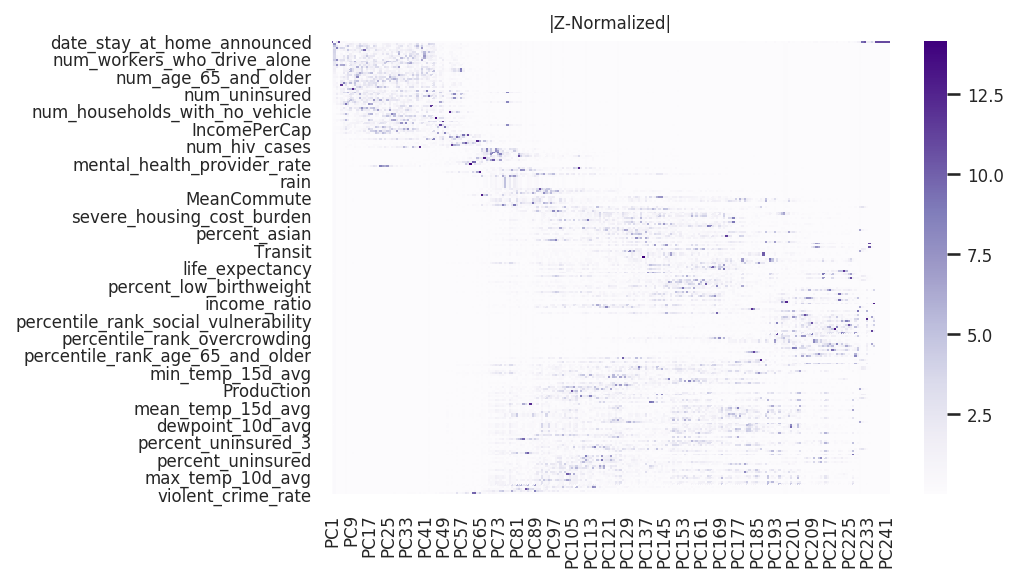

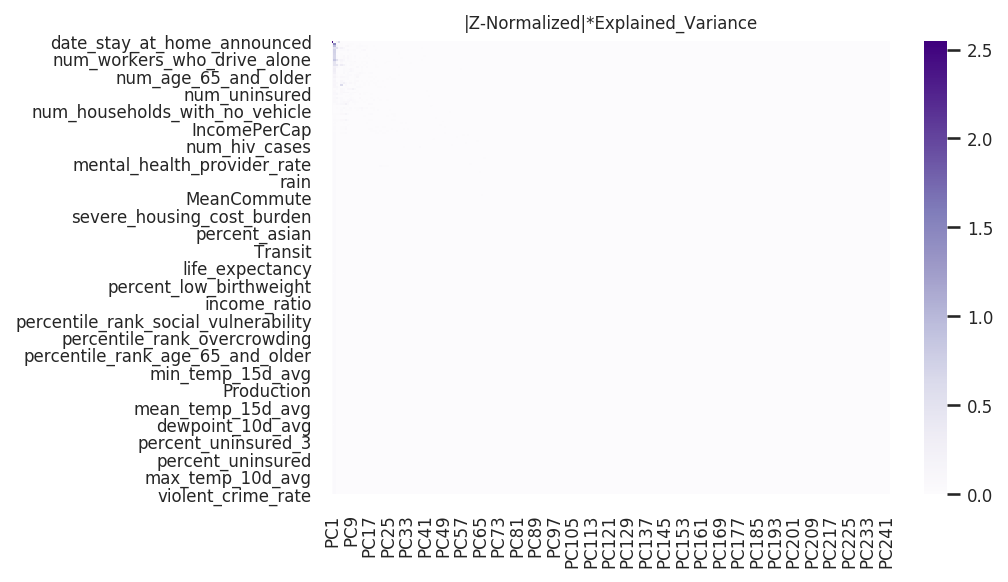

        score_                              feature_
rank                                                
1     3.385742           date_stay_at_home_announced
2     3.304775           date_stay_at_home_effective
3     2.088086                        num_minorities
4     2.029570                          num_hispanic
5     1.986568                              TotalPop
...        ...                                   ...
238   0.097176            percentile_rank_minorities
239   0.097139                         precipitation
240   0.097112         percentile_rank_below_poverty
241   0.097078  percentile_rank_social_vulnerability
242   0.097063   percentile_rank_socioeconomic_theme

[242 rows x 2 columns]


In [796]:
SMALL_SIZE = 8
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=SMALL_SIZE)
plt.rc('font', **font)
outputs = pca_full_report(X.to_numpy(), features_=X.columns.values)

## 7. Find Correlation Heatmaps for Highest Scoring Features


*--- PCA Report ---*

X mean:		158639885.913
X variance:	226365302215582112.000

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 20 to 4 dimensions while retaining 95% of variance.
2 principal components explain 89.40% of variance.
3 principal components explain 94.30% of variance.


X*X_pca: (20, 2803) * (2803, 20) = (20, 20)


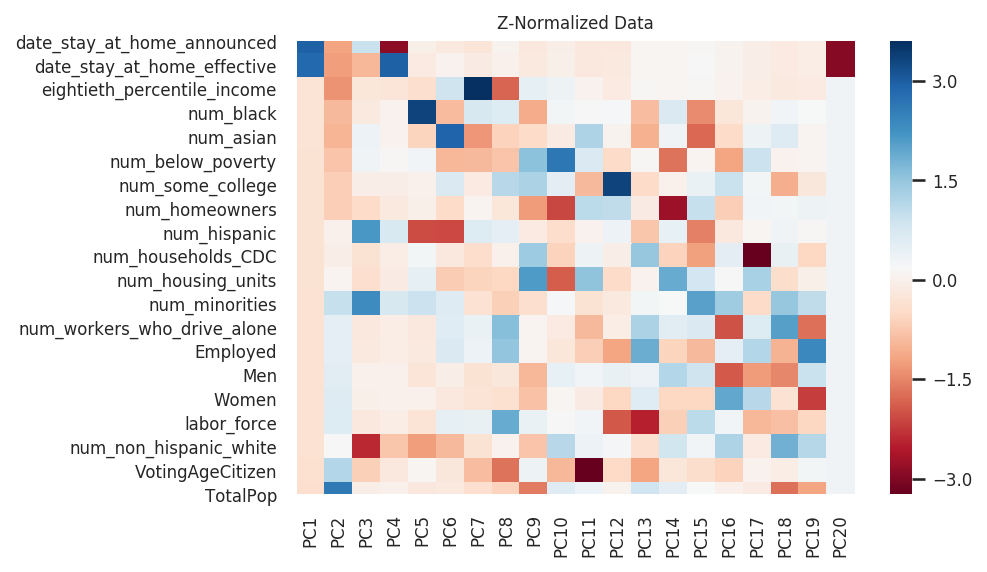

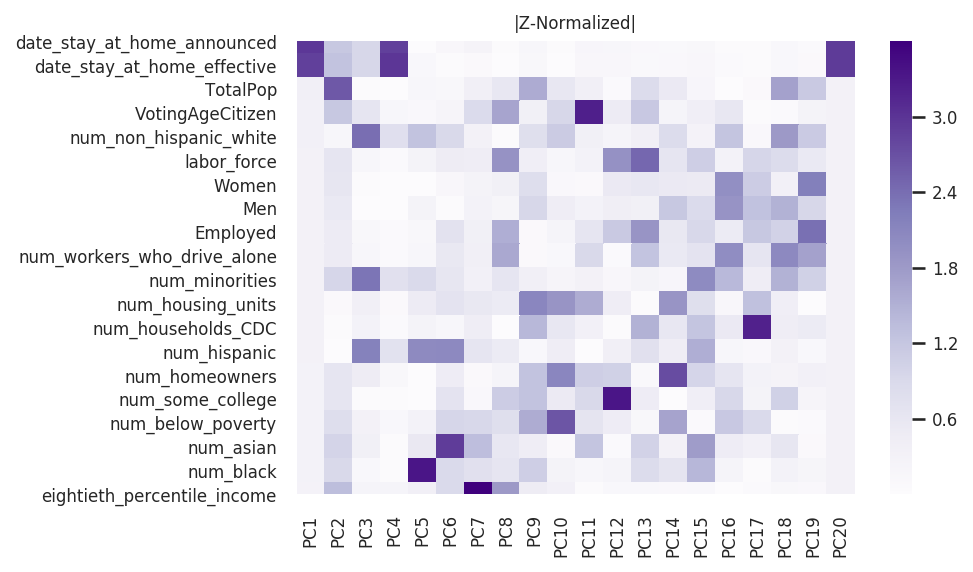

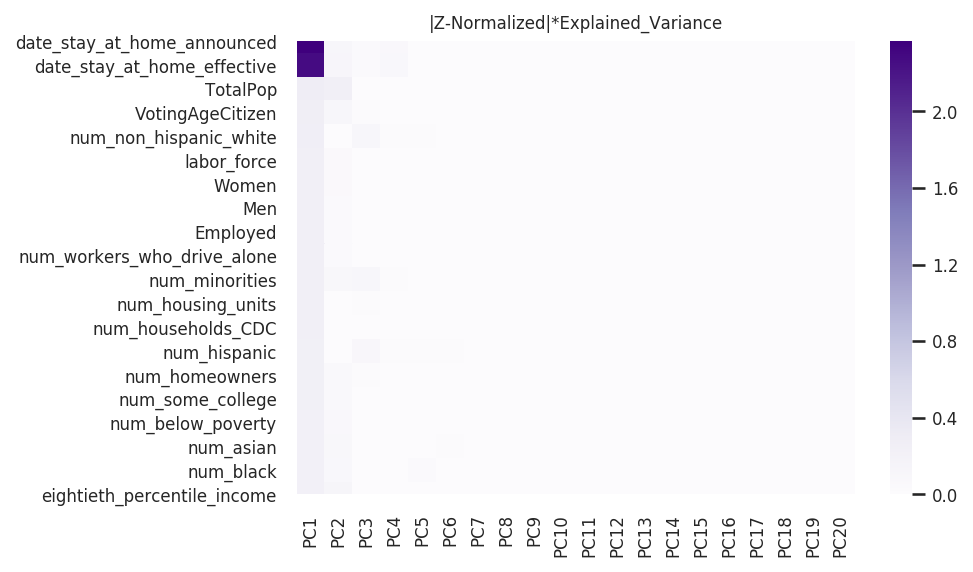

        score_                     feature_
rank                                       
1     2.614844  date_stay_at_home_announced
2     2.536303  date_stay_at_home_effective
3     0.572067                     TotalPop
4     0.515809               num_minorities
5     0.455753       num_non_hispanic_white
6     0.442578             VotingAgeCitizen
7     0.432181                 num_hispanic
8     0.407400  eightieth_percentile_income
9     0.399475                    num_black
10    0.395520                    num_asian
11    0.356928            num_below_poverty
12    0.354688                  labor_force
13    0.345342               num_homeowners
14    0.335877  num_workers_who_drive_alone
15    0.335625                     Employed
16    0.333568                        Women
17    0.327808                          Men
18    0.321676             num_some_college
19    0.306846            num_housing_units
20    0.284982           num_households_CDC


In [797]:
important_features = list(outputs[-1].head(20).feature_)
X_new = df[important_features]
outputs = pca_full_report(X_new.to_numpy(), features_=X_new.columns.values)

# References
1. https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2017_county_data.csv
2. https://www.kaggle.com/johnjdavisiv/us-counties-covid19-weather-sociohealth-data
3. http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
4. https://medium.com/cascade-bio-blog/creating-visualizations-to-better-understand-your-data-and-models-part-1-a51e7e5af9c0